## Customer Segmentation using Clustering¶

This mini-project is based on this blog post by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("C:/Users/ASHRITHA/Downloads/1479758358_clustering/clustering/WineKmC.xlsx",sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("C:/Users/ASHRITHA/Downloads/1479758358_clustering/clustering/WineKmC.xlsx",sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


# Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer.

Checkup Exercise Set I
Exercise: Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):

customer_name
One column for each offer, with a 1 if the customer responded to the offer
Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.



In [4]:
#your turn
# Merge the offers and transactions table, which are different spreadsheets in the same xls file
df = pd.merge(df_offers, df_transactions)
# Create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# Fill the NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()

## K-Means Clustering

Recall that in K-Means Clustering we want to maximize the distance between centroids and minimize the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

## Choosing K: The Elbow Sum-of-Squares Method
The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned.

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$
where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the elbow point in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly.

Checkup Exercise Set II
Exercise:

What values of $SS$ do you believe represent better clusterings? Why?
Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.
Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
What challenges did you experience using the Elbow method to pick $K$?


Text(0.5, 0, 'k')

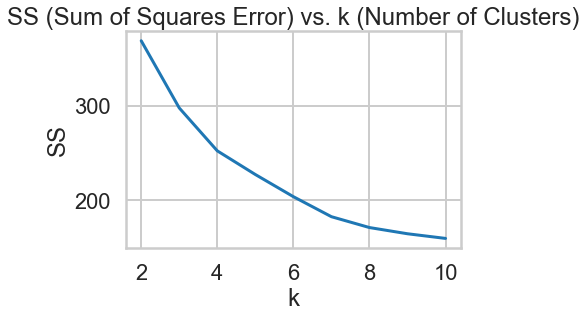

In [5]:
# your turn
from sklearn.cluster import KMeans
import numpy as np

# Save a list of the 0/1 columns
x_cols = matrix.columns[1:]

cluster = KMeans()
# Slice the matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])

# Initialize a list to store SS
SS = []

for k in range(2,11):
    km = KMeans(n_clusters=k, random_state = 13)
    km.fit(matrix[matrix.columns[2:]])
    SS.append(km.inertia_)
    
plt.plot(range(2, 11), SS)
plt.title('SS (Sum of Squares Error) vs. k (Number of Clusters)')
plt.ylabel('SS')
plt.xlabel('k')


 When looking at the sum-of-squares error ("SS"), lower values of SS represent better clusterings
Higher values of SS represent members of clusters that were farther away from their centroids, 
so a weaker clustering
Based on the visual above, using this Elbow method to choose k we would choose k = 5

# Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster and also how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the average distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$
The silhouette score is computed on every datapoint in every cluster. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.


Range	Interpretation
0.71 - 1.0	A strong structure has been found.
0.51 - 0.7	A reasonable structure has been found.
0.26 - 0.5	The structure is weak and could be artificial.
< 0.25	No substantial structure has been found.
</pre> Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called sklearn.metrics.silhouette_score. Take a look at this article on picking $K$ in scikit-learn, as it will help you in the next exercise set.

## Checkup Exercise Set III
Exercise: Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.

Exercise: Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?



For n_clusters = 2 The average silhouette_score is : 0.3721014630631728
For n_clusters = 3 The average silhouette_score is : 0.2542740543396229
For n_clusters = 4 The average silhouette_score is : 0.25082157077325035
For n_clusters = 5 The average silhouette_score is : 0.25962415123176674
For n_clusters = 6 The average silhouette_score is : 0.25004578696488833
For n_clusters = 7 The average silhouette_score is : 0.26998530857600284
For n_clusters = 8 The average silhouette_score is : 0.26854288319105574
For n_clusters = 9 The average silhouette_score is : 0.24326939512726406
For n_clusters = 10 The average silhouette_score is : 0.26472286628494485


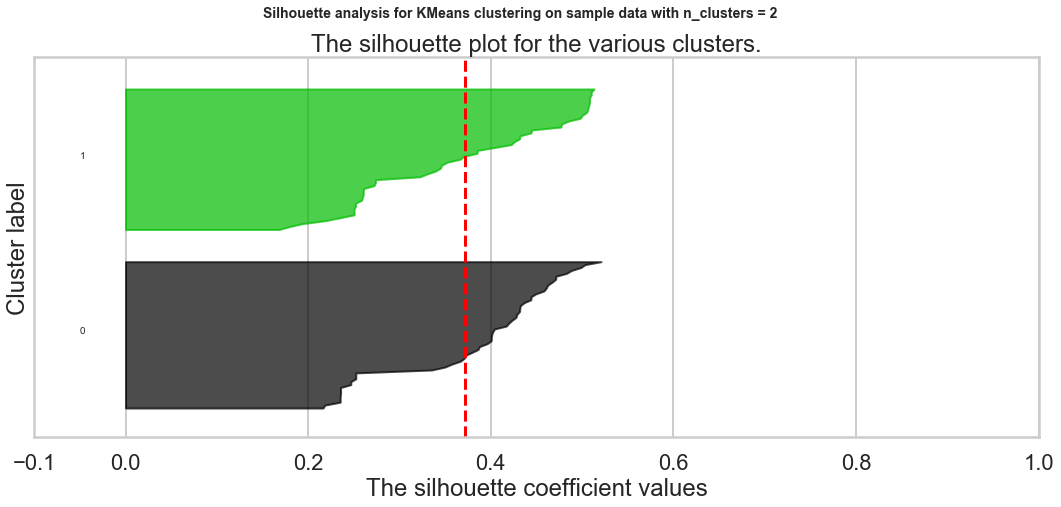

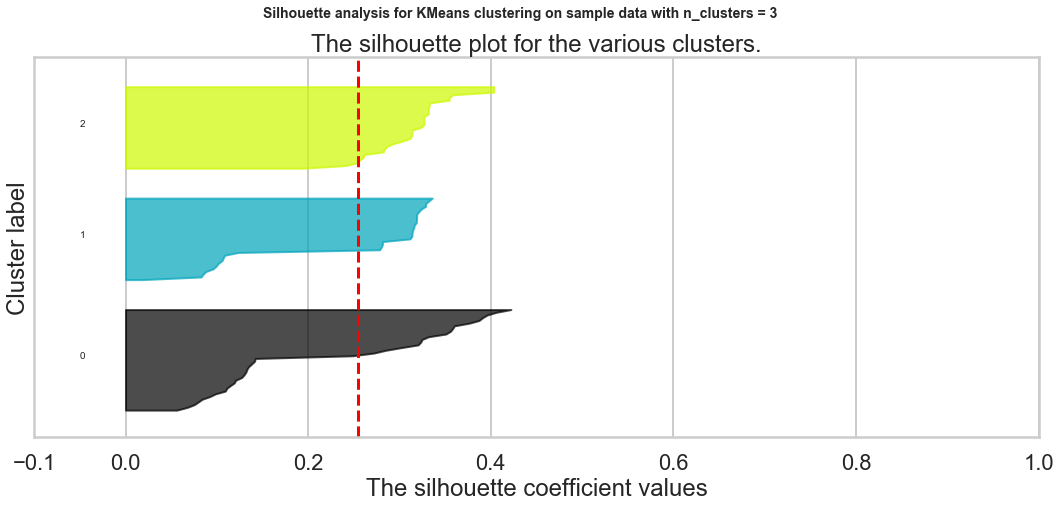

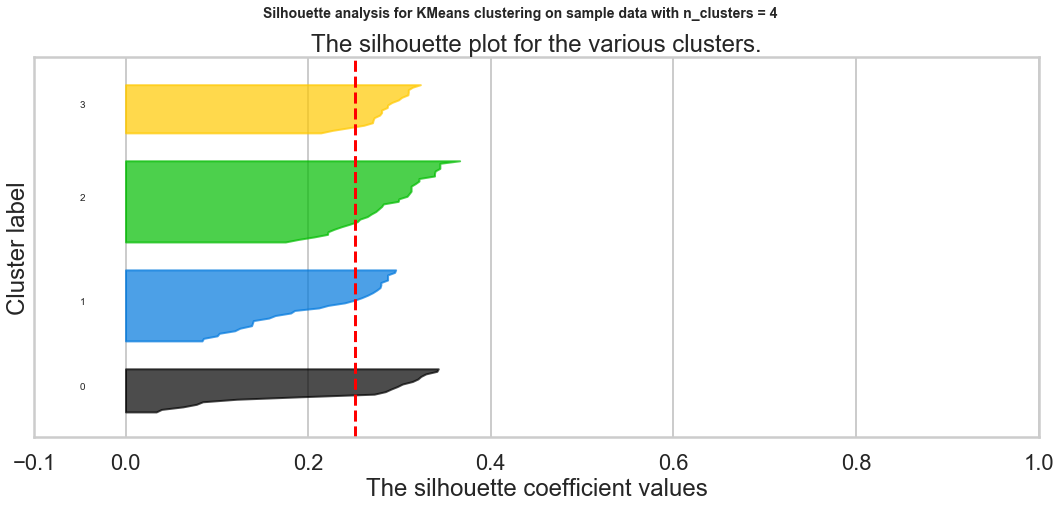

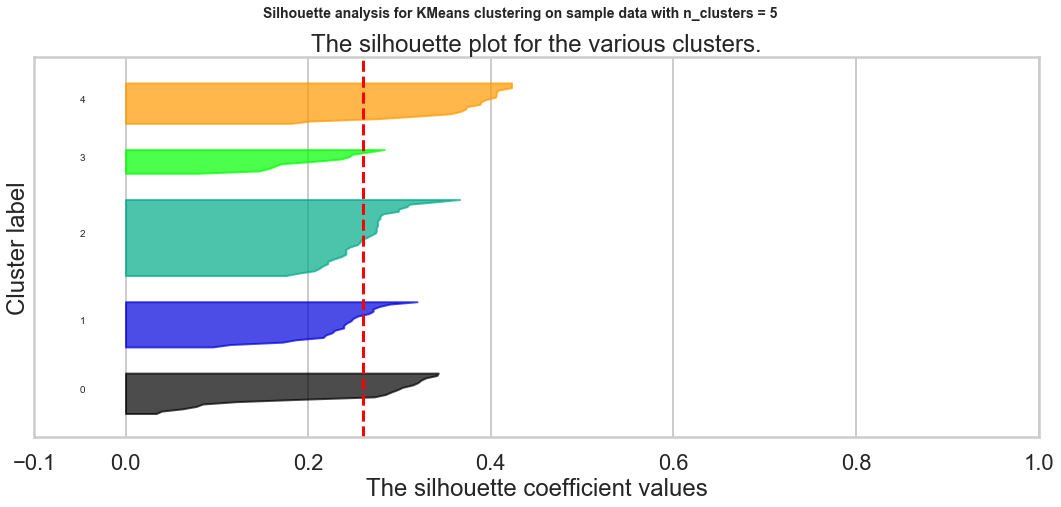

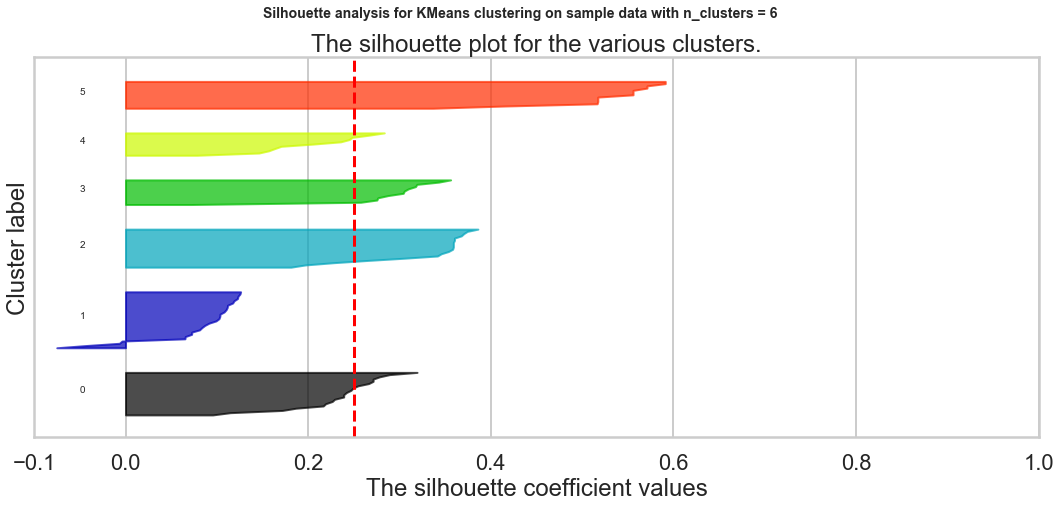

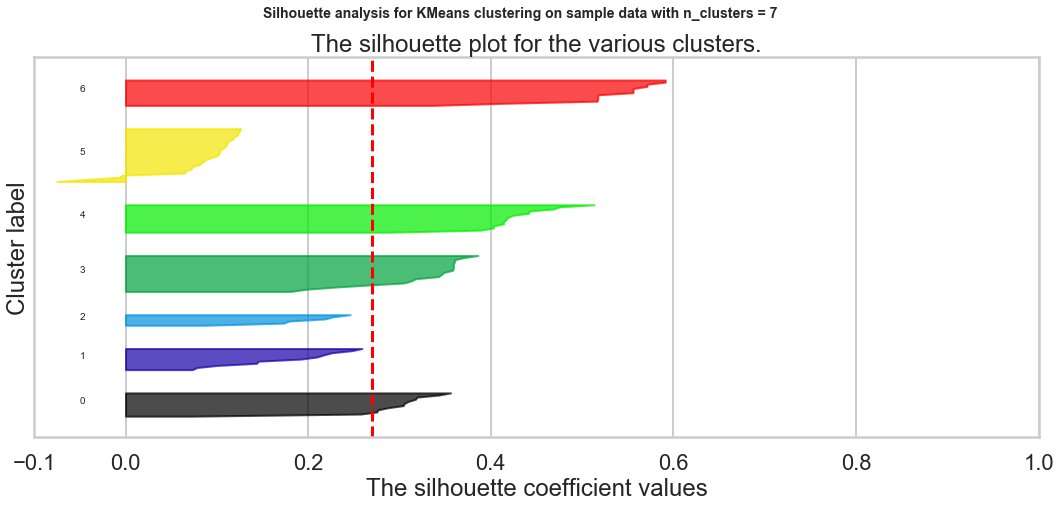

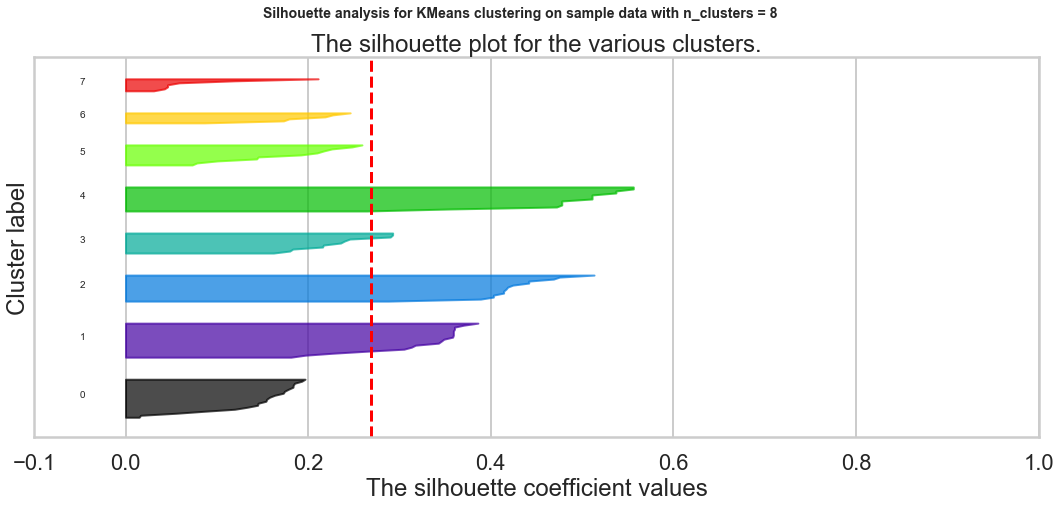

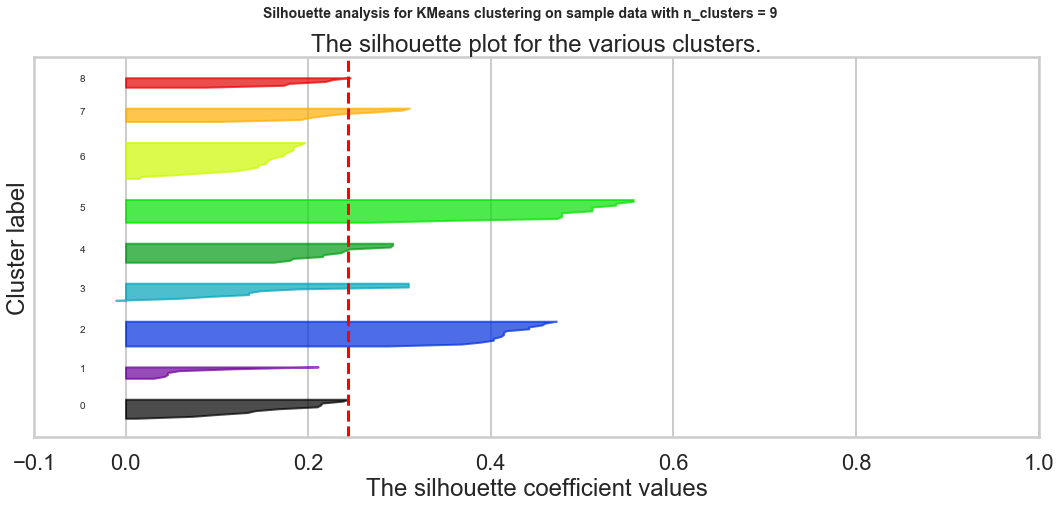

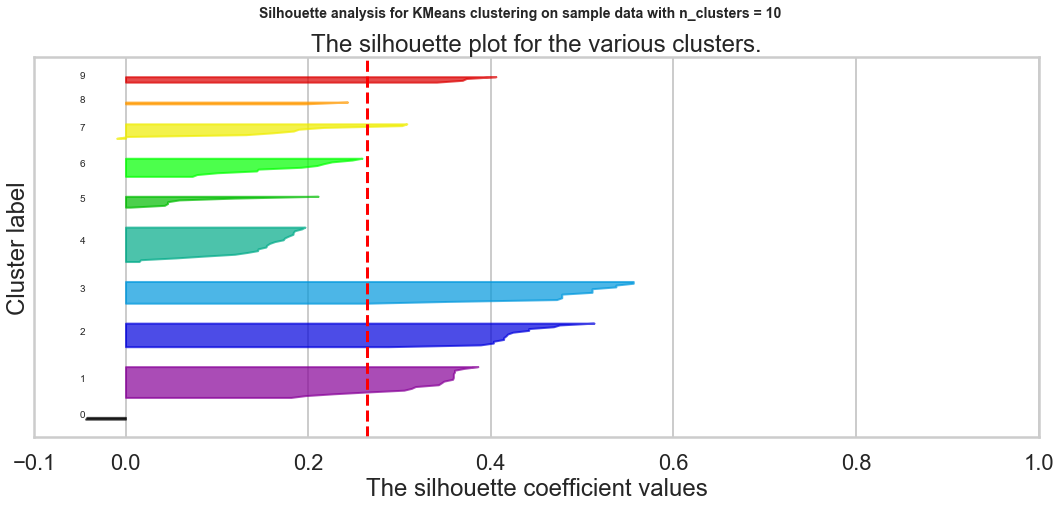

In [6]:
# Your turn.
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(matrix[matrix.columns[2:]]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=13)
    cluster_labels = clusterer.fit_predict(matrix[matrix.columns[2:]])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(matrix[matrix.columns[2:]], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix[matrix.columns[2:]], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


 The K to choose using this silhouette score is not straightforward, since there are 9 permutations of the s 
 scores with varying numbers of clusters.
We evaluated the best K to choose by averaging all 9 results and rounding it. Bed on this approach, K should be 3.
This compares to the K of 5 determined using Elbow.


## Choosing $K$: The Gap Statistic¶

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$
In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$
Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

Aside: Choosing $K$ when we Have Labels
Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

Adjusted Rand Index
Mutual Information
V-Measure
Fowlkes–Mallows index
See this article for more information about these metrics.

Visualizing Clusters using PCA
How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

Checkup Exercise Set IV
Exercise: Use PCA to plot your clusters:

Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
Create a data frame with the following fields:
customer name
cluster id the customer belongs to
the two PCA components (label them `x` and `y`)
Plot a scatterplot of the `x` vs `y` columns
Color-code points differently based on cluster ID
How do the clusters look?
Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [7]:
#your turn
from sklearn.decomposition import PCA
# We also need NumPy which we already imported above


In [8]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()


offer_id,customer_name,cluster,x,y
0,Adams,6,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,3,-0.392032,1.038391
3,Bailey,6,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


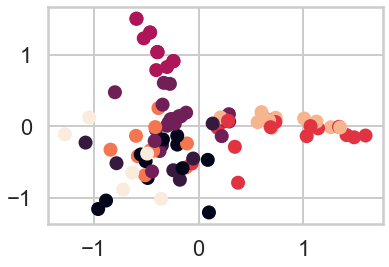

In [9]:
plt.scatter(customer_clusters['x'], customer_clusters['y'], c=customer_clusters['cluster'])


In [10]:
customer_clusters.cluster.value_counts()


2    20
4    18
6    14
3    13
5    11
0    11
1     7
7     6
Name: cluster, dtype: int64

In [11]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)


In [12]:
df['is_1'] = df.cluster ==1

In [13]:
df.groupby('is_1').varietal.value_counts()


is_1   varietal          
False  Champagne             72
       Pinot Noir            43
       Prosecco              42
       Espumante             40
       Cabernet Sauvignon    25
       Malbec                25
       Pinot Grigio          17
       Merlot                16
       Chardonnay            12
True   Champagne              9
       Cabernet Sauvignon     7
       Malbec                 7
       Merlot                 4
       Chardonnay             3
       Pinot Noir             1
       Prosecco               1
Name: varietal, dtype: int64

In [14]:
df.groupby('is_1')[['min_qty', 'discount']].mean()


,min_qty,discount
is_1,,
False,56.547945,59.410959
True,75.375000,60.125000


In [15]:
df.groupby('is_1').origin.value_counts()


is_1   origin      
False  France          111
       Australia        37
       Chile            32
       South Africa     24
       Oregon           23
       Italy            22
       Germany          16
       California       15
       New Zealand      12
True   France           17
       Chile             5
       Oregon            3
       Australia         2
       Italy             2
       California        1
       New Zealand       1
       South Africa      1
Name: origin, dtype: int64

In [16]:
df.groupby('is_1').past_peak.value_counts()


is_1   past_peak
False  False        242
       True          50
True   False         25
       True           7
Name: past_peak, dtype: int64

In [17]:
df['is_0'] = df.cluster == 0


In [18]:
df.groupby('is_0').varietal.value_counts()


is_0   varietal          
False  Champagne             61
       Pinot Noir            44
       Espumante             38
       Prosecco              33
       Malbec                31
       Cabernet Sauvignon    27
       Merlot                18
       Pinot Grigio          17
       Chardonnay            12
True   Champagne             20
       Prosecco              10
       Cabernet Sauvignon     5
       Chardonnay             3
       Espumante              2
       Merlot                 2
       Malbec                 1
Name: varietal, dtype: int64

In [19]:
df.groupby('is_0')[['min_qty', 'discount']].mean()


,min_qty,discount
is_0,,
False,55.814947,58.562278
True,75.348837,65.488372


In [20]:
df.groupby('is_1').origin.value_counts()


is_1   origin      
False  France          111
       Australia        37
       Chile            32
       South Africa     24
       Oregon           23
       Italy            22
       Germany          16
       California       15
       New Zealand      12
True   France           17
       Chile             5
       Oregon            3
       Australia         2
       Italy             2
       California        1
       New Zealand       1
       South Africa      1
Name: origin, dtype: int64

In [21]:
df.groupby('is_0').past_peak.value_counts()


is_0   past_peak
False  False        228
       True          53
True   False         39
       True           4
Name: past_peak, dtype: int64

In [22]:
# This showa us there are lots of past peak valuea.


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it x and then called the other y. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

Exercise Set V
As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?

Exercise: Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?



(-1.55, 10)

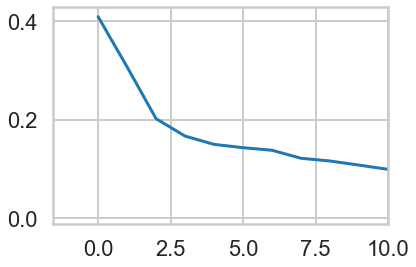

In [23]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(matrix[x_cols])

# Do the rest on your own :)
plt.plot(pca.explained_variance_)
plt.xlim(right=10)


# Based on this PCA analysis the optimal number of dimensions is 1.


Other Clustering Algorithms¶
k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn.

Affinity Propagation does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity.

Spectral Clustering uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

Ward's Method applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is divisive, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the dendogram.

Agglomerative Clustering is similar to hierarchical clustering but but is not divisive, it is agglomerative. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

DBSCAN is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

Clustering Algorithms in Scikit-learn
</tr>
</tr>
</tr>
</tr>
</tr>
</tr>
</tr>
</tr>
</tr> </tbody> </table> Source: http://scikit-learn.org/stable/modules/clustering.html
Exercise Set VI
Exercise: Try clustering using the following algorithms.

Affinity propagation
Spectral clustering
Agglomerative clustering
DBSCAN
How do their results compare? Which performs the best? Tell a story why you think it performs the best

In [24]:
# Your turn
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn import metrics


In [25]:
AP = AffinityPropagation()
APc = AP.fit(matrix[x_cols])


In [26]:
# Pulling some metrics
cluster_centers_indices = APc.cluster_centers_indices_
labels = APc.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(matrix[x_cols], labels, metric='sqeuclidean'))


Estimated number of clusters: 14
Silhouette Coefficient: 0.180


 This number of clusters using Affinity Propagation Clutering (8) is much higher than with the other approaches.


K-Means	number of clusters	Very largen_samples, medium n_clusters with MiniBatch code	General-purpose, even cluster size, flat geometry, not too many clusters	Distances between points
Affinity propagation	damping, sample preference	Not scalable with n_samples	Many clusters, uneven cluster size, non-flat geometry	Graph distance (e.g. nearest-neighbor graph)
Mean-shift	bandwidth	Not scalable with n_samples	Many clusters, uneven cluster size, non-flat geometry	Distances between points
Spectral clustering	number of clusters	Medium n_samples, small n_clusters	Few clusters, even cluster size, non-flat geometry	Graph distance (e.g. nearest-neighbor graph)
Ward hierarchical clustering	number of clusters	Large n_samples and n_clusters	Many clusters, possibly connectivity constraints	Distances between points
Agglomerative clustering	number of clusters, linkage type, distance	Large n_samples and n_clusters	Many clusters, possibly connectivity constraints, non Euclidean distances	Any pairwise distance
DBSCAN	neighborhood size	Very large n_samples, medium n_clusters	Non-flat geometry, uneven cluster sizes	Distances between nearest points
Gaussian mixtures	many	Not scalable	Flat geometry, good for density estimation	Mahalanobis distances to centers
Birch	branching factor, threshold, optional global clusterer.	Large n_clusters and n_samples	Large dataset, outlier removal, data reduction.	Euclidean distance between points
